# Task 0 - Filter Climate-Related Evidences

## 1. Load and Process Original Data

In [1]:
# Load necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount("/content/drive")
PATH_PREFIX = "/content/drive/MyDrive/Colab Notebooks/Unimelb_COMP90042_Automated_Fact_Checking"

# PATH_PREFIX = ".."

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load original data
data_tran = pd.read_json(PATH_PREFIX + "/data/data_original/train-claims.json", orient="index")
data_vald = pd.read_json(PATH_PREFIX + "/data/data_original/dev-claims.json", orient="index")
data_test = pd.read_json(PATH_PREFIX + "/data/data_original/test-claims-unlabelled.json", orient="index")
data_evdn = pd.read_json(PATH_PREFIX + "/data/data_original/evidence.json", orient="index")

In [4]:
# Function: Process claim dataframes
def df_process_claim(df, is_test=False):
    df.index = df.index.str.replace("claim-", "", regex=False).astype(int)
    df = df.reset_index().rename(columns={"index": "claim_id"})
    df = df.reset_index(drop=True)
    if not is_test:
        df["evidences"] = df["evidences"].apply(lambda x: [int(e.replace("evidence-", "")) for e in x])
    return df

# Function: Process evidence dataframe
def df_process_evidence(df):
    df.index = df.index.str.replace("evidence-", "", regex=False).astype(int)
    df = df.reset_index().rename(columns={"index": "evidence_id"})
    df = df.reset_index(drop=True)
    df = df.rename(columns={0: "evidence"})
    return df

In [5]:
# Process dataframes
df_tran = df_process_claim(data_tran, is_test=False)
df_vald = df_process_claim(data_vald, is_test=False)
df_test = df_process_claim(data_test, is_test=True)
df_evdn = df_process_evidence(data_evdn)

In [6]:
print("Training set preview:")
display(df_tran.head(3))
print("Validation set preview:")
display(df_vald.head(3))
print("Test set preview:")
display(df_test.head(3))
print("Evidence preview:")
display(df_evdn.head(3))

Training set preview:


,claim_id,claim_text,claim_label,evidences
0,1937,Not only is there no scientific evidence that ...,DISPUTED,"[442946, 1194317, 12171]"
1,126,El Niño drove record highs in global temperatu...,REFUTES,"[338219, 1127398]"
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[530063, 984887]"


Validation set preview:


,claim_id,claim_text,claim_label,evidences
0,752,[South Australia] has the most expensive elect...,SUPPORTS,"[67732, 572512]"
1,375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[996421, 1080858, 208053, 699212, 832334]"
2,1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[889933, 694262]"


Test set preview:


,claim_id,claim_text
0,2967,The contribution of waste heat to the global c...
1,979,“Warm weather worsened the most recent five-ye...
2,1609,Greenland has only lost a tiny fraction of its...


Evidence preview:


,evidence_id,evidence
0,0,"John Bennet Lawes, English entrepreneur and ag..."
1,1,Lindberg began his professional career at the ...
2,2,``Boston (Ladies of Cambridge)'' by Vampire We...


In [7]:
df_tran.to_json(PATH_PREFIX + "/data/data_task0/df_tran.json", orient="index", indent=4)
df_vald.to_json(PATH_PREFIX + "/data/data_task0/df_vald.json", orient="index", indent=4)
df_test.to_json(PATH_PREFIX + "/data/data_task0/df_test.json", orient="index", indent=4)
df_evdn.to_json(PATH_PREFIX + "/data/data_task0/df_evdn.json", orient="index", indent=4)

## 2. Prepare DataFrames for Text Preprocessing

In [8]:
# Function: Prepare dataframes with texts
def df_texts(df, df_evdn, is_test=False):

    df = df.copy()

    if not is_test:
        evidences_expanded = df["evidences"].apply(lambda x: (x + [None]*5)[:5])
        for i in range(5):
            df[f"evidence{i+1}"] = evidences_expanded.apply(
                lambda evs: df_evdn.loc[df_evdn["evidence_id"] == evs[i], "evidence"].values[0] if evs[i] is not None else None
            )
        cols = ["claim_id", "claim_text", "claim_label"] + [f"evidence{i+1}" for i in range(5)]

    else:
        for i in range(5):
            df[f"evidence{i+1}"] = None
        cols = ["claim_id", "claim_text"] + [f"evidence{i+1}" for i in range(5)]

    df_result = df[cols]
    df_result = df_result.rename(columns={"claim_id": "id", "claim_text": "claim", "claim_label": "label"})

    return df_result

In [9]:
# Prepare text dataframes
df_text_tran = df_texts(df_tran, df_evdn, is_test=False)
df_text_vald = df_texts(df_vald, df_evdn, is_test=False)
df_text_test = df_texts(df_test, df_evdn, is_test=True)
df_text_comb = pd.concat([df_text_tran, df_text_vald, df_text_test], ignore_index=True)

In [10]:
# Show processed text previews
print("Processed Training Texts preview:")
display(df_text_tran.head(3))
print("Processed Validation Texts preview:")
display(df_text_vald.head(3))
print("Processed Test Texts preview:")
display(df_text_test.head(3))
print("Processed Combined Texts preview:")
display(df_text_comb.head(3))

Processed Training Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5
0,1937,Not only is there no scientific evidence that ...,DISPUTED,At very high concentrations (100 times atmosph...,Plants can grow as much as 50 percent faster i...,Higher carbon dioxide concentrations will favo...,None,None
1,126,El Niño drove record highs in global temperatu...,REFUTES,While ‘climate change’ can be due to natural f...,This acceleration is due mostly to human-cause...,None,None,None
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,There is evidence of reversals in the prevaili...,"1945/1946: The PDO changed to a ""cool"" phase, ...",None,None,None


Processed Validation Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5
0,752,[South Australia] has the most expensive elect...,SUPPORTS,[citation needed] South Australia has the high...,"""South Australia has the highest power prices ...",None,None,None
1,375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,The 2011 UNEP Green Economy report states that...,With a market share of 30% and (potentially) c...,"In the modern era, emissions to the atmosphere...","Cumulative anthropogenic (i.e., human-emitted)...",Other countries with fast growing emissions ar...
2,1266,This means that the world is now 1C warmer tha...,SUPPORTS,Multiple independently produced instrumental d...,The planet is now 0.8 °C warmer than in pre-in...,None,None,None


Processed Test Texts preview:


,id,claim,evidence1,evidence2,evidence3,evidence4,evidence5
0,2967,The contribution of waste heat to the global c...,None,None,None,None,None
1,979,“Warm weather worsened the most recent five-ye...,None,None,None,None,None
2,1609,Greenland has only lost a tiny fraction of its...,None,None,None,None,None


Processed Combined Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5
0,1937,Not only is there no scientific evidence that ...,DISPUTED,At very high concentrations (100 times atmosph...,Plants can grow as much as 50 percent faster i...,Higher carbon dioxide concentrations will favo...,None,None
1,126,El Niño drove record highs in global temperatu...,REFUTES,While ‘climate change’ can be due to natural f...,This acceleration is due mostly to human-cause...,None,None,None
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,There is evidence of reversals in the prevaili...,"1945/1946: The PDO changed to a ""cool"" phase, ...",None,None,None


## 3. Preprocess Texts

### 3.1 Preprocess Text DataFrames - Train, Vald, Test

In [11]:
# Import libraries for text preprocessing
## Text preprocessing
import nltk
nltk.download("stopwords")  # Download NLTK stopwords
import spacy
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("spaCy model 'en_core_web_lg' not found, downloading...")
    spacy.cli.download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")
## Stopwords
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
## Punctuation
from string import punctuation

# Sets of stopwords & punctuation & English alphabets
SET_PUNCTUATION = set(punctuation) | set(["“", "”", "‘", "’", "—", "–"])
SET_STOPWORDS = (set(stopwords.words("english")).union(
                 set(ENGLISH_STOP_WORDS)).union(
                 set(["January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December",
                      "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])))
SET_ENGLISH_ALPHABETS = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Function: text preprocessing
def tp_combined(text):
    # Remove punctuation and digits
    text = "".join([char for char in text
                    if char not in SET_PUNCTUATION
                    and not char.isdigit()
                    ])
    # Remove non-English words
    text = " ".join([word for word in text.split() if all(char in SET_ENGLISH_ALPHABETS for char in word)])
    # Tokenization & lemmatization - keep only nouns and proper nouns & remove stopwords
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha
        and token.pos_ in ["NOUN", "PROPN"]
        and token.lemma_ not in SET_STOPWORDS
        and token.lemma_ not in SET_PUNCTUATION
    ]
    # Lowercase & remove single-character tokens & remove duplicates
    tokens = [token.lower() for token in tokens if len(token) > 1]
    # Remove duplicates and return
    return list(set(tokens))

In [13]:
# Function: Tokenize dataframe texts
def df_tokenize(df):
    df = df.copy()
    def combine_tokens(row):
        tokens = set()
        cols  = ["claim"] + [f"evidence{i}" for i in range(1, 6)]
        for col in cols:
            ev = row.get(col)
            if ev is not None:
                tokens.update(tp_combined(ev))
        return sorted(list(tokens))
    df["tokens"] = df.apply(combine_tokens, axis=1)
    return df

In [14]:
# Tokenize text dataframes for training set
path_df_token_tran = PATH_PREFIX + "/data/data_task0/df_token_tran.json"
if os.path.exists(path_df_token_tran):
    df_token_tran = pd.read_json(path_df_token_tran, orient="index")
    if len(df_token_tran) == len(df_text_tran):
        print("Training tokenized file exists and has correct length, loading from file.")
    else:
        print("Training tokenized file exists but length mismatch, reprocessing.")
        df_token_tran = df_tokenize(df_text_tran)
        df_token_tran.to_json(path_df_token_tran, orient="index", indent=4)
else:
    print("Training tokenized file does not exist, processing.")
    df_token_tran = df_tokenize(df_text_tran)
    df_token_tran.to_json(path_df_token_tran, orient="index", indent=4)

# Tokenize text dataframes for validation set
path_df_token_vald = PATH_PREFIX + "/data/data_task0/df_token_vald.json"
if os.path.exists(path_df_token_vald):
    df_token_vald = pd.read_json(path_df_token_vald, orient="index")
    if len(df_token_vald) == len(df_text_vald):
        print("Validation tokenized file exists and has correct length, loading from file.")
    else:
        print("Validation tokenized file exists but length mismatch, reprocessing.")
        df_token_vald = df_tokenize(df_text_vald)
        df_token_vald.to_json(path_df_token_vald, orient="index", indent=4)
else:
    print("Validation tokenized file does not exist, processing.")
    df_token_vald = df_tokenize(df_text_vald)
    df_token_vald.to_json(path_df_token_vald, orient="index", indent=4)

# Tokenize text dataframes for test set
path_df_token_test = PATH_PREFIX + "/data/data_task0/df_token_test.json"
if os.path.exists(path_df_token_test):
    df_token_test = pd.read_json(path_df_token_test, orient="index")
    if len(df_token_test) == len(df_text_test):
        print("Test tokenized file exists and has correct length, loading from file.")
    else:
        print("Test tokenized file exists but length mismatch, reprocessing.")
        df_token_test = df_tokenize(df_text_test)
        df_token_test.to_json(path_df_token_test, orient="index", indent=4)
else:
    print("Test tokenized file does not exist, processing.")
    df_token_test = df_tokenize(df_text_test)
    df_token_test.to_json(path_df_token_test, orient="index", indent=4)

# Tokenize text dataframes for combined set
path_df_token_comb = PATH_PREFIX + "/data/data_task0/df_token_comb.json"
if os.path.exists(path_df_token_comb):
    df_token_comb = pd.read_json(path_df_token_comb, orient="index")
    if len(df_token_comb) == len(df_text_comb):
        print("Combined tokenized file exists and has correct length, loading from file.")
    else:
        print("Combined tokenized file exists but length mismatch, reprocessing.")
        df_token_comb = df_tokenize(df_text_comb)
        df_token_comb.to_json(path_df_token_comb, orient="index", indent=4)
else:
    print("Combined tokenized file does not exist, processing.")
    df_token_comb = df_tokenize(df_text_comb)
    df_token_comb.to_json(path_df_token_comb, orient="index", indent=4)

Training tokenized file exists and has correct length, loading from file.
Validation tokenized file exists and has correct length, loading from file.
Test tokenized file exists and has correct length, loading from file.
Combined tokenized file exists and has correct length, loading from file.


In [15]:
# Show tokenized previews
print("Tokenized Training Texts preview:")
display(df_token_tran.head(3))
print("Tokenized Validation Texts preview:")
display(df_token_vald.head(3))
print("Tokenized Test Texts preview:")
display(df_token_test.head(3))
print("Tokenized Combined Texts preview:")
display(df_token_comb.head(3))

Tokenized Training Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5,tokens
0,1937,Not only is there no scientific evidence that ...,DISPUTED,At very high concentrations (100 times atmosph...,Plants can grow as much as 50 percent faster i...,Higher carbon dioxide concentrations will favo...,None,None,"[animal, carbon, change, climate, co, concentr..."
1,126,El Niño drove record highs in global temperatu...,REFUTES,While ‘climate change’ can be due to natural f...,This acceleration is due mostly to human-cause...,None,None,None,"[acceleration, activity, change, climate, el, ..."
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,There is evidence of reversals in the prevaili...,"1945/1946: The PDO changed to a ""cool"" phase, ...",None,None,None,"[american, amplitude, change, coast, episode, ..."


Tokenized Validation Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5,tokens
0,752,[South Australia] has the most expensive elect...,SUPPORTS,[citation needed] South Australia has the high...,"""South Australia has the highest power prices ...",None,None,None,"[australia, citation, country, electricity, po..."
1,375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,The 2011 UNEP Green Economy report states that...,With a market share of 30% and (potentially) c...,"In the modern era, emissions to the atmosphere...","Cumulative anthropogenic (i.e., human-emitted)...",Other countries with fast growing emissions ar...,"[aagricultural, atmosphere, australia, carbon,..."
2,1266,This means that the world is now 1C warmer tha...,SUPPORTS,Multiple independently produced instrumental d...,The planet is now 0.8 °C warmer than in pre-in...,None,None,None,"[baseline, dataset, decade, planet, time, world]"


Tokenized Test Texts preview:


,id,claim,evidence1,evidence2,evidence3,evidence4,evidence5,tokens
0,2967,The contribution of waste heat to the global c...,NaN,NaN,NaN,NaN,NaN,"[climate, contribution, heat, waste, wm]"
1,979,“Warm weather worsened the most recent five-ye...,NaN,NaN,NaN,NaN,NaN,"[drought, period, precipitation, record, term,..."
2,1609,Greenland has only lost a tiny fraction of its...,NaN,NaN,NaN,NaN,NaN,"[fraction, greenland, ice, mass]"


Tokenized Combined Texts preview:


,id,claim,label,evidence1,evidence2,evidence3,evidence4,evidence5,tokens
0,1937,Not only is there no scientific evidence that ...,DISPUTED,At very high concentrations (100 times atmosph...,Plants can grow as much as 50 percent faster i...,Higher carbon dioxide concentrations will favo...,None,None,"[animal, carbon, change, climate, co, concentr..."
1,126,El Niño drove record highs in global temperatu...,REFUTES,While ‘climate change’ can be due to natural f...,This acceleration is due mostly to human-cause...,None,None,None,"[acceleration, activity, change, climate, el, ..."
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,There is evidence of reversals in the prevaili...,"1945/1946: The PDO changed to a ""cool"" phase, ...",None,None,None,"[american, amplitude, change, coast, episode, ..."


### 3.2 Preprocess Text DataFrame - Evidence

In [16]:
# Function: Parallel tokenization
def parallel_tp_combined(texts, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend="threading")(
        delayed(tp_combined)(text) for text in tqdm(texts, desc="Tokenizing", total=len(texts))
    )
    return results

In [17]:
# Tokenize evidence dataframe
path_df_token_evdn = PATH_PREFIX + "/data/data_task0/df_token_evdn.json"

if os.path.exists(path_df_token_evdn):
    df_token_evdn = pd.read_json(path_df_token_evdn, orient="index")
    if len(df_token_evdn) == len(df_evdn):
        print("Evidence tokenized file exists and has correct length, loading from file.")
    else:
        print("Evidence tokenized file exists but length mismatch, reprocessing.")
        df_token_evdn = df_evdn.copy()
        df_token_evdn["tokens"] = parallel_tp_combined(df_token_evdn["evidence"])
        df_token_evdn.to_json(path_df_token_evdn, orient="index", indent=4)
else:
    print("Evidence tokenized file does not exist, processing.")
    df_token_evdn = df_evdn.copy()
    df_token_evdn["tokens"] = parallel_tp_combined(df_token_evdn["evidence"])
    df_token_evdn.to_json(path_df_token_evdn, orient="index", indent=4)

Evidence tokenized file exists and has correct length, loading from file.


In [18]:
# Show processed evidence preview
print("Processed Evidence Texts preview:")
df_token_evdn.head()

Processed Evidence Texts preview:


,evidence_id,evidence,tokens
0,0,"John Bennet Lawes, English entrepreneur and ag...","[entrepreneur, english, lawes, bennet, john, s..."
1,1,Lindberg began his professional career at the ...,"[new, york, age, career, city, lindberg]"
2,2,``Boston (Ladies of Cambridge)'' by Vampire We...,"[weekend, boston, vampire, ladies, cambridge]"
3,3,"Gerald Francis Goyer (born October 20, 1936) w...","[gerald, hockey, national, league, francis, pl..."
4,4,He detected abnormalities of oxytocinergic fun...,"[abnormality, function, postpartum, oxytocin, ..."


## 4. Match Evidences with Claims

### 4.1 Match Evidences with Claims by Token Overlap

In [19]:
# Function: Prepare evidence list for matching
def prepare_evidence_list(df_evidences):
    return [(int(row["evidence_id"]), set(row["tokens"])) for _, row in df_evidences.iterrows()]

# Function: Match single claim against evidence list
def match_single_claim(claim_row, evidence_list, threshold=2):
    global tqdm_match
    # accept either Series or dict (joblib may serialize differently) -> normalize to dict
    if not isinstance(claim_row, dict):
        try:
            claim_row = claim_row.to_dict()
        except Exception:
            claim_row = {}

    claim_tokens = set(claim_row.get("tokens", []))
    matched = [int(e_id) for e_id, e_tokens in evidence_list if len(claim_tokens & e_tokens) >= min(threshold, len(claim_tokens))]

    # update progress bar if present (works with threading backend)
    try:
        if tqdm_match is not None:
            tqdm_match.update(1)
    except Exception:
        pass

    return matched

# Function: Match claims to evidences in parallel
def match_evidences(df_claims, df_evidences, threshold=2, n_jobs=-1, backend="threading"):
    global tqdm_match
    df_claims = df_claims.copy()
    evidence_list = prepare_evidence_list(df_evidences)
    # create tqdm instance for tracking completed tasks (threading backend required)
    tqdm_match = tqdm(total=len(df_claims), desc="Matching claims")
    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(match_single_claim)(row.to_dict() if hasattr(row, "to_dict") else dict(row), evidence_list, threshold)
        for _, row in df_claims.iterrows()
    )
    tqdm_match.close()
    tqdm_match = None
    if results:
        df_claims["evidences_matched"] = list(results)
    else:
        df_claims["evidences_matched"] = []
    return df_claims

In [20]:
# Match evidences for training sets
path_df_token_tran_matched = PATH_PREFIX + "/data/data_task0/df_tran_matched.json"
if os.path.exists(path_df_token_tran_matched):
    print("Training matched file exists, loading from file.")
    df_token_tran_matched = pd.read_json(path_df_token_tran_matched, orient="index")
else:
    print("Training matched file does not exist, processing.")
    df_token_tran_matched = match_evidences(df_token_tran, df_token_evdn, threshold=2, n_jobs=-1)
    df_token_tran_matched = pd.merge(df_token_tran_matched, df_tran, left_on="id", right_on="claim_id", how="inner")
    df_token_tran_matched = df_token_tran_matched[["id", "claim", "label", "evidences", "evidences_matched"]]
    df_token_tran_matched["evidences_mismatched"] = df_token_tran_matched.apply(lambda row: list(set(row["evidences_matched"]) - set(row["evidences"])), axis=1)
    df_token_tran_matched["evidences_missed"] = df_token_tran_matched.apply(lambda row: list(set(row["evidences"]) - set(row["evidences_matched"])), axis=1)
    df_token_tran_matched.to_json(path_df_token_tran_matched, orient="index", indent=4)

# Match evidences for validation sets
path_df_token_vald_matched = PATH_PREFIX + "/data/data_task0/df_vald_matched.json"
if os.path.exists(path_df_token_vald_matched):
    print("Validation matched file exists, loading from file.")
    df_token_vald_matched = pd.read_json(path_df_token_vald_matched, orient="index")
else:
    print("Validation matched file does not exist, processing.")
    df_token_vald_matched = match_evidences(df_token_vald, df_token_evdn, threshold=2, n_jobs=-1)
    df_token_vald_matched = pd.merge(df_token_vald_matched, df_vald, left_on="id", right_on="claim_id", how="inner")
    df_token_vald_matched = df_token_vald_matched[["id", "claim", "label", "evidences", "evidences_matched"]]
    df_token_vald_matched["evidences_mismatched"] = df_token_vald_matched.apply(lambda row: list(set(row["evidences_matched"]) - set(row["evidences"])), axis=1)
    df_token_vald_matched["evidences_missed"] = df_token_vald_matched.apply(lambda row: list(set(row["evidences"]) - set(row["evidences_matched"])), axis=1)
    df_token_vald_matched.to_json(path_df_token_vald_matched, orient="index", indent=4)

# Match evidences for test sets
path_df_token_test_matched = PATH_PREFIX + "/data/data_task0/df_test_matched.json"
if os.path.exists(path_df_token_test_matched):
    print("Test matched file exists, loading from file.")
    df_token_test_matched = pd.read_json(path_df_token_test_matched, orient="index")
else:
    print("Test matched file does not exist, processing.")
    df_token_test_matched = match_evidences(df_token_test, df_token_evdn, threshold=2, n_jobs=-1)
    df_token_test_matched = pd.merge(df_token_test_matched, df_test, left_on="id", right_on="claim_id", how="inner")
    df_token_test_matched = df_token_test_matched[["id", "claim", "evidences_matched"]]
    df_token_test_matched.to_json(path_df_token_test_matched, orient="index", indent=4)

Training matched file exists, loading from file.
Validation matched file exists, loading from file.
Test matched file exists, loading from file.


In [21]:
# Show preview of matched evidences
print("Matched Evidences preview:")
display(df_token_tran_matched.head(3))
print("Validation Matched Evidences preview:")
display(df_token_vald_matched.head(3))
print("Test Matched Evidences preview:")
display(df_token_test_matched.head(3))

Matched Evidences preview:


,id,claim,label,evidences,evidences_matched,evidences_mismatched,evidences_missed
0,1937,Not only is there no scientific evidence that ...,DISPUTED,"[442946, 1194317, 12171]","[215, 315, 441, 526, 783, 968, 1018, 1135, 119...","[491521, 917507, 393220, 32773, 819207, 475144...",[]
1,126,El Niño drove record highs in global temperatu...,REFUTES,"[338219, 1127398]","[301, 441, 1018, 1135, 1236, 1579, 1758, 1823,...","[491521, 917507, 32773, 327686, 1130503, 47514...",[]
2,2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[530063, 984887]","[74, 215, 226, 301, 357, 411, 552, 680, 694, 8...","[491521, 1146885, 655369, 688143, 1114128, 229...",[]


Validation Matched Evidences preview:


,id,claim,label,evidences,evidences_matched,evidences_mismatched,evidences_missed
0,752,[South Australia] has the most expensive elect...,SUPPORTS,"[67732, 572512]","[16, 37, 89, 514, 608, 1001, 1291, 1457, 1577,...","[1114115, 933896, 786443, 917516, 16, 262162, ...",[]
1,375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[996421, 1080858, 208053, 699212, 832334]","[16, 37, 410, 414, 441, 465, 514, 608, 783, 80...","[524291, 917507, 720899, 1114115, 786443, 16, ...",[]
2,1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[889933, 694262]","[975, 1061, 1830, 2487, 4035, 4321, 5354, 6025...","[856065, 520194, 1036290, 1114114, 692229, 565...",[]


Test Matched Evidences preview:


,id,claim,evidences_matched
0,2967,The contribution of waste heat to the global c...,"[1460, 8304, 11688, 13436, 19067, 22107, 26773..."
1,979,“Warm weather worsened the most recent five-ye...,"[10368, 13434, 16837, 19622, 21546, 27162, 289..."
2,1609,Greenland has only lost a tiny fraction of its...,"[5928, 10210, 19306, 29169, 32006, 44485, 4475..."


### 4.2 Summary Statistics of Matched Evidences

Average matched evidences:
Training set average matched evidences: 8998.81
Validation set average matched evidences: 8247.99
Test set average matched evidences: 1289.40
Overall average matched evidences: 8155.06


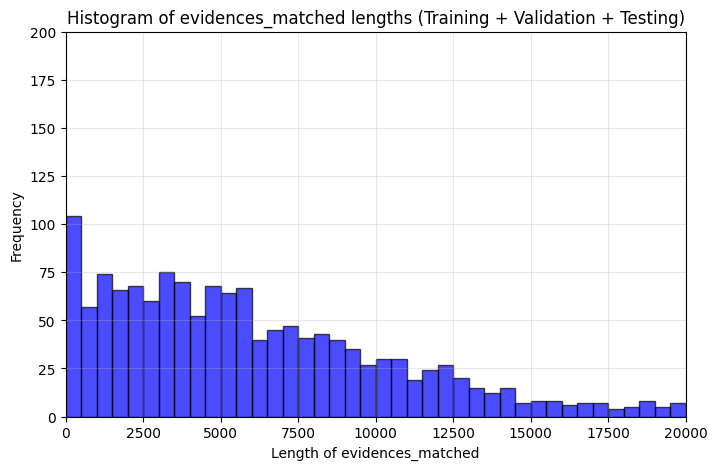

In [22]:
# Calculate lengths of evidences_matched for each dataset
len_match_tran = df_token_tran_matched["evidences_matched"].apply(len)
len_match_vald = df_token_vald_matched["evidences_matched"].apply(len)
len_match_test = df_token_test_matched["evidences_matched"].apply(len)
len_match_all = list(len_match_tran) + list(len_match_vald) + list(len_match_test)

print(f"Average matched evidences:")
print(f"Training set average matched evidences: {len_match_tran.mean():.2f}")
print(f"Validation set average matched evidences: {len_match_vald.mean():.2f}")
print(f"Test set average matched evidences: {len_match_test.mean():.2f}")
print(f"Overall average matched evidences: {sum(len_match_all) / len(len_match_all):.2f}")

# Plot histogram for lengths of evidences_matched with all datasets combined
plt.figure(figsize=(8, 5))
plt.hist(len_match_all, bins=range(0, 20001, 500), alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Length of evidences_matched")
plt.ylabel("Frequency")
plt.title("Histogram of evidences_matched lengths (Training + Validation + Testing)")
plt.xlim(0, 20000)
plt.ylim(0, 200)
plt.grid(True, alpha=0.3)
plt.show()

Average mismatched evidences:
Training set average mismatched evidences: 8995.49
Validation set average mismatched evidences: 8244.84
Overall average mismatched evidences: 8911.84



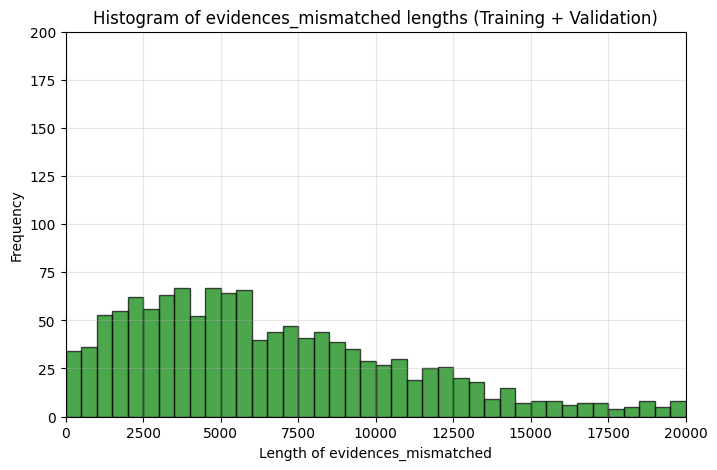

In [23]:
# Calculate lengths of evidences_mismatched for each dataset
len_mismatched_tran = df_token_tran_matched["evidences_mismatched"].apply(len)
len_mismatched_vald = df_token_vald_matched["evidences_mismatched"].apply(len)
len_mismatched_all = list(len_mismatched_tran) + list(len_mismatched_vald)

print(f"Average mismatched evidences:")
print(f"Training set average mismatched evidences: {len_mismatched_tran.mean():.2f}")
print(f"Validation set average mismatched evidences: {len_mismatched_vald.mean():.2f}")
print(f"Overall average mismatched evidences: {sum(len_mismatched_all) / len(len_mismatched_all):.2f}")
print()

# Plot histogram for lengths of evidences_mismatched with all datasets combined
plt.figure(figsize=(8, 5))
plt.hist(len_mismatched_all, bins=range(0, 20001, 500), alpha=0.7, color="green", edgecolor="black")
plt.xlabel("Length of evidences_mismatched")
plt.ylabel("Frequency")
plt.title("Histogram of evidences_mismatched lengths (Training + Validation)")
plt.xlim(0, 20000)
plt.ylim(0, 200)
plt.grid(True, alpha=0.3)
plt.show()

Average missed evidences:
Training set average missed evidences: 0.03
Validation set average missed evidences: 0.04
Overall average missed evidences: 0.03


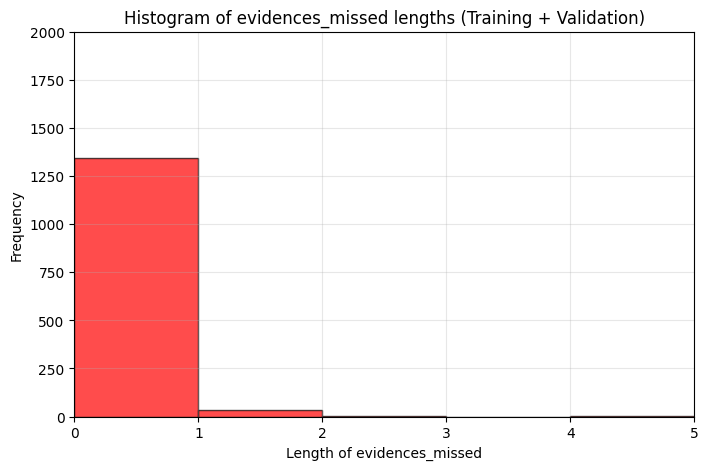

In [24]:
# Calcualte lenths of evidences_missed for each dataset
len_missed_tran = df_token_tran_matched["evidences_missed"].apply(len)
len_missed_vald = df_token_vald_matched["evidences_missed"].apply(len)
len_missed_all = list(len_missed_tran) + list(len_missed_vald)

print(f"Average missed evidences:")
print(f"Training set average missed evidences: {len_missed_tran.mean():.2f}")
print(f"Validation set average missed evidences: {len_missed_vald.mean():.2f}")
print(f"Overall average missed evidences: {sum(len_missed_all) / len(len_missed_all):.2f}")

# Plot histogram for lengths of evidences_missed with all datasets combined
plt.figure(figsize=(8, 5))
plt.hist(len_missed_all, bins=range(0, 6, 1), alpha=0.7, color="red", edgecolor="black")
plt.xlabel("Length of evidences_missed")
plt.ylabel("Frequency")
plt.title("Histogram of evidences_missed lengths (Training + Validation)")
plt.xlim(0, 5)
plt.ylim(0, 2000)
plt.grid(True, alpha=0.3)
plt.show()